In [1]:
import os
# os.environ['KERAS_BACKEND'] = "plaidml.keras.backend"

from keras import Sequential
from keras.layers import Dense, LSTM, Input,SimpleRNN, Embedding,concatenate
from keras.models import Model
from keras.optimizers import RMSprop
from keras.preprocessing.sequence import pad_sequences
from keras import losses
from keras.utils.data_utils import get_file
import numpy as np
import pandas as pd
import random
import sys
import io
import util
from sklearn.feature_extraction.text import TfidfVectorizer
import embeddings
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk import word_tokenize
import ast
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
df = pd.read_csv('./data/collections_all_science_out-temp_lda.csv')

In [3]:
word2vec = Word2Vec.load('./Word2Vec_100dim_science')

def Word2doc(sentence,dim):
    words=sentence.strip().split()
    emb=np.zeros(dim)
    for word in words:
        if(word in word2vec.wv.vocab):
            emb = np.add(emb,word2vec[word])
    return np.array(emb/len(words))

In [4]:
Doc2vec_model= Doc2Vec.load("./doc2vec_100dim_science.model")
 
def Doc2vec(sentence,dim):
    emb = np.zeros(dim) 
    emb += Doc2vec_model.infer_vector(word_tokenize(sentence.strip().lower()))
    return np.array(emb)

In [5]:
df['avg_word_emb'] = df.Summarization.apply(lambda x: Word2doc(x,100))
df['doc_emb'] = df.Summarization.apply(lambda x: Doc2vec(x,100))

/Users/vibhavagarwal/miniconda2/envs/dl_plaidml/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [6]:
df['lda_topics'] = df.lda_topics.apply(lambda x : [b for _ ,b in ast.literal_eval(x) ])

In [7]:
df['input_vec'] = df.apply(lambda x: np.append(x['doc_emb'],x['lda_topics']),axis=1)

In [8]:
col = util.generate_collections(df)
df_col = util.generate_valid_collections_df(col)

In [9]:
rand_col = util.generate_random_collections(df,2000,7)
df_rand = util.generate_random_collections_df(rand_col)

In [10]:
maxlen = df_col.sequence_ids.apply(len).max()
maxlen

27

In [11]:
np.array(df.avg_word_emb.iloc[1]).shape

(100,)

In [12]:
df_col.lda_topicss.iloc[2].shape

(3, 20)

In [13]:
np.array(df_col.input_vecs.iloc[800]).shape

(9, 120)

In [14]:
print(df_rand.avg_word_embs.iloc[1].shape,
df_rand.doc_embs.iloc[1].shape,
df_rand.lda_topicss.iloc[1].shape,
df_rand.loc[1,['avg_word_embs','doc_embs']].shape)

(7, 100) (7, 100) (7, 20) (2,)


In [130]:
df_rand.loc[1,['avg_word_embs','doc_embs']]

avg_word_embs    [[1.4545282169335312, -0.31021296256972897, 0....
doc_embs         [[0.06542465090751648, 0.06451678276062012, -0...
Name: 1, dtype: object

In [34]:
emb_inp = Input(shape=(None,100), dtype='float32', name='emb_inp')
lstm_emb = LSTM(units=32)(emb_inp)

# lda_inp = Input(shape=(None,20), dtype='float32', name='lda_inp')
# lstm_lda = LSTM(units=32)(lda_inp)

# x = concatenate([lstm_emb, lstm_lda])
# x = Dense(64, activation='relu')(lstm_emb)

main_output = Dense(1, activation='sigmoid')(lstm_emb)
model = Model(inputs=emb_inp, outputs=main_output)
model.compile(optimizer=RMSprop(lr=0.01), loss='binary_crossentropy',metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emb_inp (InputLayer)         (None, None, 100)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 17,057
Trainable params: 17,057
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# model = Sequential()
# # if os.environ['KERAS_BACKEND'] == "plaidml.keras.backend":
# #     model.add(LSTM(128,input_shape=((maxlen,200)),activation='relu',return_sequences = True))
# # else:
# model.add(LSTM(128,input_shape=((None,200)),activation='relu',return_sequences = True))

# # model.add(LSTM(128,activation='relu'))
# # model.add(Dense(32,activation='relu'))
# model.add(Dense(2,activation='softmax'))

# opt = RMSprop(lr=0.01)
# loss = losses.sparse_categorical_crossentropy

# model.compile(loss=loss,optimizer = opt ,metrics=['accuracy'])
# print(model.summary())

In [16]:
df_temp = pd.concat([df_col,df_rand])

In [17]:
print(df_rand.avg_word_embs.iloc[1].shape,
df_rand.doc_embs.iloc[1].shape,
df_rand.lda_topicss.iloc[1].shape,
df_rand.loc[1,['avg_word_embs','doc_embs']].shape)

(7, 100) (7, 100) (7, 20) (2,)


In [18]:
df_temp.columns

Index(['Summarizations', 'avg_word_embs', 'collection_ids', 'descriptions',
       'doc_embs', 'input_vecs', 'lda_topicss', 'resource_ids', 'sequence_ids',
       'titles', 'label'],
      dtype='object')

In [19]:
X_features = ['input_vecs']
y_features = ['label']

In [26]:
X_train,X_test,y_train,y_test = train_test_split(
    df_temp.loc[:,X_features],
    df_temp.loc[:,y_features],
    train_size = 0.7,
    random_state = 42)

In [25]:
X_train_a,X_test_a,= train_test_split(
    a,
    train_size = 0.7,
    random_state = 42)
X_train_b,X_test_b,= train_test_split(
    b,
    train_size = 0.7,
    random_state = 42)

In [80]:
np.array(df_temp.label.iloc[1]).reshape((1)).shape

(1,)

In [21]:
pad_seq = np.append(Doc2vec('',100),np.zeros((20,),dtype=np.float32)).reshape((1,120))

In [22]:
b = pad_sequences(df_temp.input_vecs, maxlen=maxlen, padding='pre', truncating='pre', value=pad_seq)

In [26]:
X_train_a.shape

(2375, 27, 100)

In [48]:
X_train

,input_vecs
994,"[[-0.0051881070248782635, -0.00976557191461324..."
464,"[[-0.016842983663082123, -0.006098925601691008..."
1097,"[[0.011188735254108906, -0.04139195755124092, ..."
1073,"[[0.05768248811364174, -0.06761698424816132, 0..."
1959,"[[0.060076210647821426, -0.07149750739336014, ..."
1503,"[[-0.02931893616914749, -0.132253497838974, -0..."
264,"[[0.2936093807220459, -0.09095210582017899, -0..."
657,"[[-0.0006760904798284173, -0.01210224628448486..."
152,"[[0.018935564905405045, -0.016658401116728783,..."
212,"[[0.06294336915016174, -0.030179565772414207, ..."


In [41]:
history = model.fit(
    {
        "emb_inp": X_train
#         "emb_inp": df_temp.input_vecs.iloc[1].reshape((1,1,120))
#         ,"lda_inp": X_train_b
    },
    y_train,
    epochs = 200 
    ,validation_data =(
        X_test_a,
        y_test
    )
)

ValueError: Error when checking input: expected emb_inp to have 3 dimensions, but got array with shape (2375, 1)

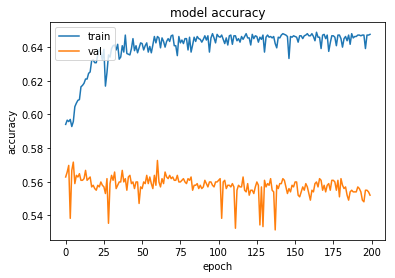

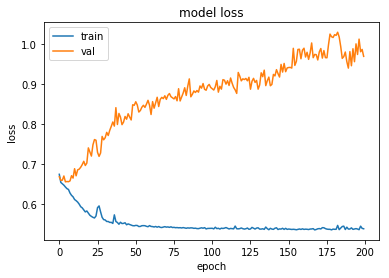

In [36]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('./200ep_ac.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('./200ep_loss.png')
plt.show()


In [232]:
def append_data(data,length):
    empty_embd = Doc2vec('',100).reshape(1,100)
    for i in range(maxlen-length):
        data = np.append(data,empty_embd,axis=0)
    return data
df_temp['doc_embs_'] = df_temp.apply(lambda row : append_data(row['doc_embs'],len(row['sequence_ids'])),axis=1)

In [24]:
a = pad_sequences(df_temp.doc_embs, maxlen=maxlen, padding='pre', truncating='pre', value=Doc2vec('',100).reshape(1,100))

In [107]:
b = pad_sequences(df_temp.lda_topicss, maxlen=maxlen, padding='pre', truncating='pre', value=np.zeros((maxlen,20)))

In [67]:
df_col[df_col.sequence_ids.apply(len)>4].shape

(336, 11)

In [38]:
a = df.groupby(df.collection_id).count()

In [40]:
a.groupby(a.resource_id).count()

,title,url,created_at,updated_at,creator_id,modifier_id,original_creator_id,original_content_id,parent_content_id,publish_date,...,primary_language,max_score,Summarization,text,clean,clean_matrix,lda_topics,avg_word_emb,doc_emb,input_vec
resource_id,,,,,,,,,,,,,,,,,,,,,
1,242,242,242,242,242,242,242,242,242,242,...,242,242,242,242,242,242,242,242,242,242
2,335,335,335,335,335,335,335,335,335,335,...,335,335,335,335,335,335,335,335,335,335
3,302,302,302,302,302,302,302,302,302,302,...,302,302,302,302,302,302,302,302,302,302
4,178,178,178,178,178,178,178,178,178,178,...,178,178,178,178,178,178,178,178,178,178
5,140,140,140,140,140,140,140,140,140,140,...,140,140,140,140,140,140,140,140,140,140
6,52,52,52,52,52,52,52,52,52,52,...,52,52,52,52,52,52,52,52,52,52
7,47,47,47,47,47,47,47,47,47,47,...,47,47,47,47,47,47,47,47,47,47
8,31,31,31,31,31,31,31,31,31,31,...,31,31,31,31,31,31,31,31,31,31
9,21,21,21,21,21,21,21,21,21,21,...,21,21,21,21,21,21,21,21,21,21


In [49]:
dt = pd.read_csv('./data/collections_all.csv')

In [50]:
len(dt.collection_id.unique())

9503

In [52]:
a = dt.groupby(dt.collection_id).count()

In [55]:
a[a.sequence_id>4].shape

(3859, 39)